In [2]:
from pyspark.sql import SparkSession
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin


spark = SparkSession.builder.master("local").appName("keyword_count").getOrCreate()
sc= spark.sparkContext

def getBigLinks(url):    
    req = requests.get(url)
    
    soup = BeautifulSoup(req.content, "html.parser")
    
    li_tag = soup.find_all("li", class_=["thoisu","thegioi","kinhdoanh", "batdongsan", "khoahoc", "giaitri", "thethao", "phapluat", "giaoduc", "suckhoe", "doisong", "dulich", "sohoa", "xe", "ykien"])
  

    hrefList = []
    if li_tag:
      for li in li_tag:
        a_tag = li.find('a') 
        if a_tag:
            href = a_tag.get("href")
            full_url = urljoin(url, href)
            hrefList.append(full_url) 
            
    return hrefList

def getTitleBigLinks(url, hf):
    req = requests.get(url) 
    soup = BeautifulSoup(req.content, "html.parser")
    title = soup.find_all("a", href=hf)
    
    if title:
        for t in title:
            return t.get("title")


In [3]:
from pyspark.sql import SparkSession
from bs4 import BeautifulSoup
import requests

spark = SparkSession.builder.master("local").appName("keyword_count").getOrCreate()
sc= spark.sparkContext

def scrape_websites_getLink(url):    
  req = requests.get(url)

  if req.url == "https://timkiem.vnexpress.net":
        return 0

  soup = BeautifulSoup(req.content, "html.parser")

  h3_tag = soup.find_all("h3", class_="title-news")
  h1_tag = soup.find_all("h1", class_="title-news")
  h2_tag = soup.find_all("h2", class_="title-news")

  hrefList = []
  if h1_tag:
      for h1 in h1_tag:
        a_tag = h1.find('a') 
        if a_tag:
            href = a_tag.get("href")
            hrefList.append(href) 

  if h2_tag:
      for h2 in h2_tag:
        a_tag = h2.find('a') 
        if a_tag:
            href = a_tag.get("href")
            hrefList.append(href) 
            
  if h3_tag:
      for h3 in h3_tag:
        a_tag = h3.find('a') 
        if a_tag:
            href = a_tag.get("href")
            hrefList.append(href) 
            
  to_remove = "https://video.vnexpress.net/"
  filtered_hrefList = [href for href in hrefList if not href.startswith(to_remove)]
  return filtered_hrefList



In [4]:
from pyspark.sql import SparkSession
from bs4 import BeautifulSoup
import requests


def scrape_website(url, inputFile):
  req = requests.get(url)

  soup = BeautifulSoup(req.content, "html.parser")

  pTagList = soup.find_all("p", class_="Normal")

  textList = []

  for pTag in pTagList:
    text = pTag.get_text()
    textList.append(text)

  allTest = "\n".join(textList)

  with open(inputFile, "w", encoding="utf-8") as file:
    file.write(allTest)



In [5]:
def get_title(url):
  req = requests.get(url)

  soup = BeautifulSoup(req.content, "html.parser")

  title = soup.title.string
  return title


def get_content():
    getContent = sc.textFile("output.txt")
    getContent_ = "\n".join (getContent.collect())
    return getContent_


def get_description(url):
    req = requests.get(url)
    
    soup = BeautifulSoup(req.content, "html.parser")
    
    p = soup.find_all("p", class_="description")
    for p_ in p:       
        return p_.text



In [6]:
def read_inputFile_write_outputFile(inputFile, outputFile) :
  with open(inputFile, "r", encoding="utf-8") as input_file:
      lines = input_file.readlines()
  filtered_lines = [line.strip() for line in lines if line.strip()]
  with open(outputFile, "w", encoding="utf-8") as output_file:
      output_file.writelines("\n".join(filtered_lines))



In [7]:
def read_sort_outputFile(outputFile):
  text = sc.textFile(outputFile)
  # inn_text.collect()
  stop_words = [
    "cả", "các", "cần", "càng", "là", "lại", "theo", "đó", "có", "của", 
    "để", "đến", "điều", "ở", "rằng", "ra", "và", "với", "còn", "ở", 
    "khi", "từ", "ngày", "này", "chúng", "như"
  ]
  # Tách từ và chuyển thành chữ thường
  text_flat = text.flatMap(lambda x: x.split(' ')).map(lambda x: (x.lower(), 1))

  text_filtered = text_flat.filter(lambda x: x[0] not in stop_words)
  text_counts = text_filtered.reduceByKey(lambda x, y: x + y)
  sort_text = text_counts.sortBy(lambda x: x[1], ascending=False).collect()
  return sort_text

In [8]:
def start(url):
    # i = 0
    # while True:
      inputFile = "input.txt"
      scrape_website(url, inputFile)
    
      outputFile = "output.txt"
      read_inputFile_write_outputFile(inputFile, outputFile)
    
      sort_text =  read_sort_outputFile(outputFile)
      return sort_text
      # print(sort_text)
      # columns =["words", "values"]
      # df = spark.createDataFrame(sort_text,columns)
    
      # df.show()
      # i += 1
      # print(i)
    
      # if i==5 :
      #   break
      # time.sleep(10)


In [13]:
import psycopg2 as p
import psycopg2.extras as pe
import os

hostname = '127.0.0.1'
database = 'news_page_keywords'
username = 'postgres'
password = 'test123456'
port = 5432
conn = None

while True:
    try:
        with p.connect(host = hostname, dbname = database, user = username, password = password, port = port ) as conn:
            with conn.cursor(cursor_factory = pe.DictCursor) as cur:
                cur.execute('''DELETE FROM news WHERE content IS NULL OR content = '' ''')

                # truy cap vao tung url 
                url = "https://vnexpress.net"
                bigLinks =  getBigLinks(url)
                for base_url in bigLinks :
                    i = 1
                    while True:
                        url = f"{base_url}-p{i}"
                        getLinks = scrape_websites_getLink(url)
                        
                        hf = '/'+base_url.split("/")[-1]
                        genre = getTitleBigLinks(base_url, hf)
                        
                        if getLinks == 0 :
                            print(f"Đã quét tới trang {i} của bài báo {genre} và trang này không tồn tại\n")
                            print('**********************************************************************************\n')
                            break
                        print('**********************************************************************************')
                        print(f"Đã quét tới trang {i} của bài báo {genre}\nCó url là: {base_url}")
                        print('**********************************************************************************\n')
                        # truy cap vao tung link trong danh sach vua nhan duoc tu 1 ham`
                        for link in getLinks :
                            # lay url, noi dung, title, result : bao gom keyword va so lan xuat hien
                            result = start(link)
                            title = get_title(link)
                            content =get_content()
                            description = get_description(link)
                
                            # kiem tra xem cac table co data chua
                            cur.execute('SELECT * FROM news WHERE source = %s', (link,))
                            news = cur.fetchone()
                
                            if not news:
                                # insert vao bang news
                                insert_script_news = '''INSERT INTO news (title,description ,content,genre ,source)
                                                   VALUES (%s, %s, %s, %s ,%s) RETURNING id_news'''
                                insert_value_news= (title, description, content, genre ,link)
                                cur.execute(insert_script_news, insert_value_news)
                                # lay id cua bang news
                                id_news = cur.fetchone()['id_news']
                    
                    
                                # insert vao bang keywords
                                insert_script_keywords = '''INSERT INTO keywords (keyword)
                                                   VALUES (%s) RETURNING id_keywords'''
                                result_getKeywords = []
                                # lay ra keywords trong list result
                                for data in result:
                                    result_getKeywords.append(data[0])
                                id_keywords = []
                                for data in result_getKeywords:
                                    cur.execute(insert_script_keywords,(data,))
                                    # lay id cua bang keywords
                                    id_keywords.append(cur.fetchone()['id_keywords'])
                    
                    
                                # insert vao bang new_keywords
                                insert_script_news_keywords = '''INSERT INTO news_keywords (id_news, id_keywords)
                                                   VALUES (%s, %s) RETURNING id_news'''
                                for id_keys in id_keywords :
                                    cur.execute(insert_script_news_keywords,(id_news,id_keys))
                    
                                
                                 # insert vao bang keyword_statistics
                                insert_script_keyword_statistics = '''INSERT INTO keyword_statistics (id_keywords, count)
                                                   VALUES (%s, %s) RETURNING id'''
                                # gom 2 list vao 1 list
                                combined = list(zip(id_keywords, result))
                                id_keyword_statistics = []
                                for id_kw, rs in combined :
                                    cur.execute(insert_script_keyword_statistics,(id_kw,rs[1]))
                                    id_keyword_statistics.append(cur.fetchone()['id'])
                    
                                print(f"Đang tiến hành lưu  bài báo: {title}\nCó url là:{link}\n")
                                conn.commit()
                            else: 
                                result_getKeywords = []
                                for data in result:
                                    result_getKeywords.append(data[0])

                                get_id_news = '''SELECT id_news FROM news WHERE source = %s'''
                                cur.execute(get_id_news, (link,))                 
                                id_news = cur.fetchone()['id_news']
                               
                                
                    
                                get_id_keyword = '''SELECT id_keywords FROM news_keywords WHERE id_news = %s'''
                                cur.execute(get_id_keyword, (id_news,))
                                id_keywords = []
                                for data in cur.fetchall():
                                    id_keywords.append(data['id_keywords'])

                                
                               
                                    
                                placeholders = ', '.join(['%s'] * len(id_keywords))
                                get_keyword = f'''SELECT keyword FROM keywords WHERE id_keywords IN ({placeholders})'''
                                cur.execute(get_keyword, id_keywords)
                    
                                keywords = []
                                for data in cur.fetchall():
                                    keywords.append(data['keyword'])
                               
            
                                # kiem tra id_keywords_file co giong voi keywords vua quet khong , kiem tra xem co them tu gi khong trong top5
                                if set(keywords[:5]) == set(result_getKeywords[:5]):
                                    print(f"\nBài báo: {title} không thay đổi , có url là : {link}\n")
                                else:
                                    # xem nhung tu ma` list vua` quet data tren web co ma trong keywords_file khong co va nam trong top 5
                                    difference = list(set(result_getKeywords[:5]) - set(keywords[:5]))
                                    
                                    if  difference :
                                        # update top5 keywords
                                        id_keywords_temp = id_keywords
                                        top5_id_keywords = id_keywords[:5]
                                        top5_rs_keywords_count =result[:5]
                                        combined_1 = list(zip(top5_rs_keywords_count, top5_id_keywords))
                                        for rs_keywords, id_keywords in combined_1 :
                                            cur.execute('UPDATE keywords SET keyword = %s WHERE id_keywords = %s', (rs_keywords[0], id_keywords))  
                                        
                                        # update top5 bang keyword_statistics
                                        id = []
                                        get_id_keyword_statistics = f'''SELECT id FROM keyword_statistics WHERE id_keywords IN ({placeholders})'''
                                        cur.execute(get_id_keyword_statistics, id_keywords_temp)
                                        for data in cur.fetchall():
                                            id.append(data[0])

                                        top5_id_keyword_statistics = id[:5]
                                        combined_2 = list(zip(top5_rs_keywords_count, top5_id_keyword_statistics))
                                        for count, id_kw_st in combined_2 :
                                            cur.execute('''UPDATE keyword_statistics SET count = %s, statistics_day = DEFAULT
                                            WHERE id = %s''', (count[1], id_kw_st))   
                                        
                                        conn.commit()
                                        print(f"\nBài báo: {title} đã thay đổi , có url là : {link}")
                                        print("da update.")
                                    else:
                                        print('dont need to update')
                        i += 1
                        print('\n')
    except Exception as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
        
            
            


**********************************************************************************
Đã quét tới trang 1 của bài báo Thời sự
Có url là: https://vnexpress.net/thoi-su
**********************************************************************************




Bài báo: Nạn nhân vụ cháy chung cư mini ngóng chờ phương án hỗ trợ - VnExpress không thay đổi , có url là : https://vnexpress.net/nan-nhan-vu-chay-chung-cu-mini-ngong-cho-phuong-an-ho-tro-4671023.html


Bài báo: TP HCM trả tối đa 10 triệu đồng mua tin phòng, chống tham nhũng - VnExpress không thay đổi , có url là : https://vnexpress.net/tp-hcm-tra-toi-da-10-trieu-dong-mua-tin-phong-chong-tham-nhung-4671106.html


Bài báo: Tai nạn giao thông liên hoàn ở Lạng Sơn, 5 người chết không thay đổi , có url là : https://vnexpress.net/tai-nan-lien-hoan-5-nguoi-chet-4671097.html


Bài báo: Phó thủ tướng: Không đẩy việc khó cho địa phương khi định giá đất - VnExpress không thay đổi , có url là : https://vnexpress.net/pho-thu-tuong-khong-day-viec-kho-cho-dia-phuong-khi-dinh-gia-dat-4671008.html


Bài báo: Ba người bị lũ cuốn - VnExpress không thay đổi , có url là : https://vnexpress.net/ba-nguoi-bi-lu-cuon-4670996.html


Bài báo: Hà Tĩnh mưa lớn, lũ dâng cao - VnExpress không thay đổi , có url là 

KeyboardInterrupt: 

In [9]:
import psycopg2 as p
import psycopg2.extras as pe

hostname = '127.0.0.1'
database = 'news_page_keywords'
username = 'postgres'
password = 'test123456'
port = 5432
conn = None


try:
    with p.connect(host = hostname, dbname = database, user = username, password = password, port = port ) as conn:
        with conn.cursor(cursor_factory = pe.DictCursor) as cur:
            # in ra so luong bai bao 

            countNews = '''SELECT COUNT(*) FROM news'''
            cur.execute(countNews)
            print(f"Đã thu thập được dữ liệu của: {cur.fetchone()[0]} bài báo")
except Exception as error:
    print(error)
finally:
    if conn is not None:
        conn.close()

        
        


Đã thu thập được dữ liệu của: 9909 bài báo


23/11/01 00:31:36 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


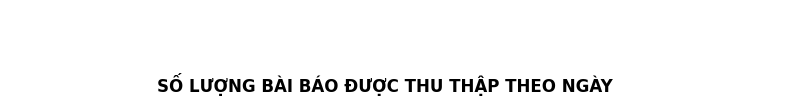

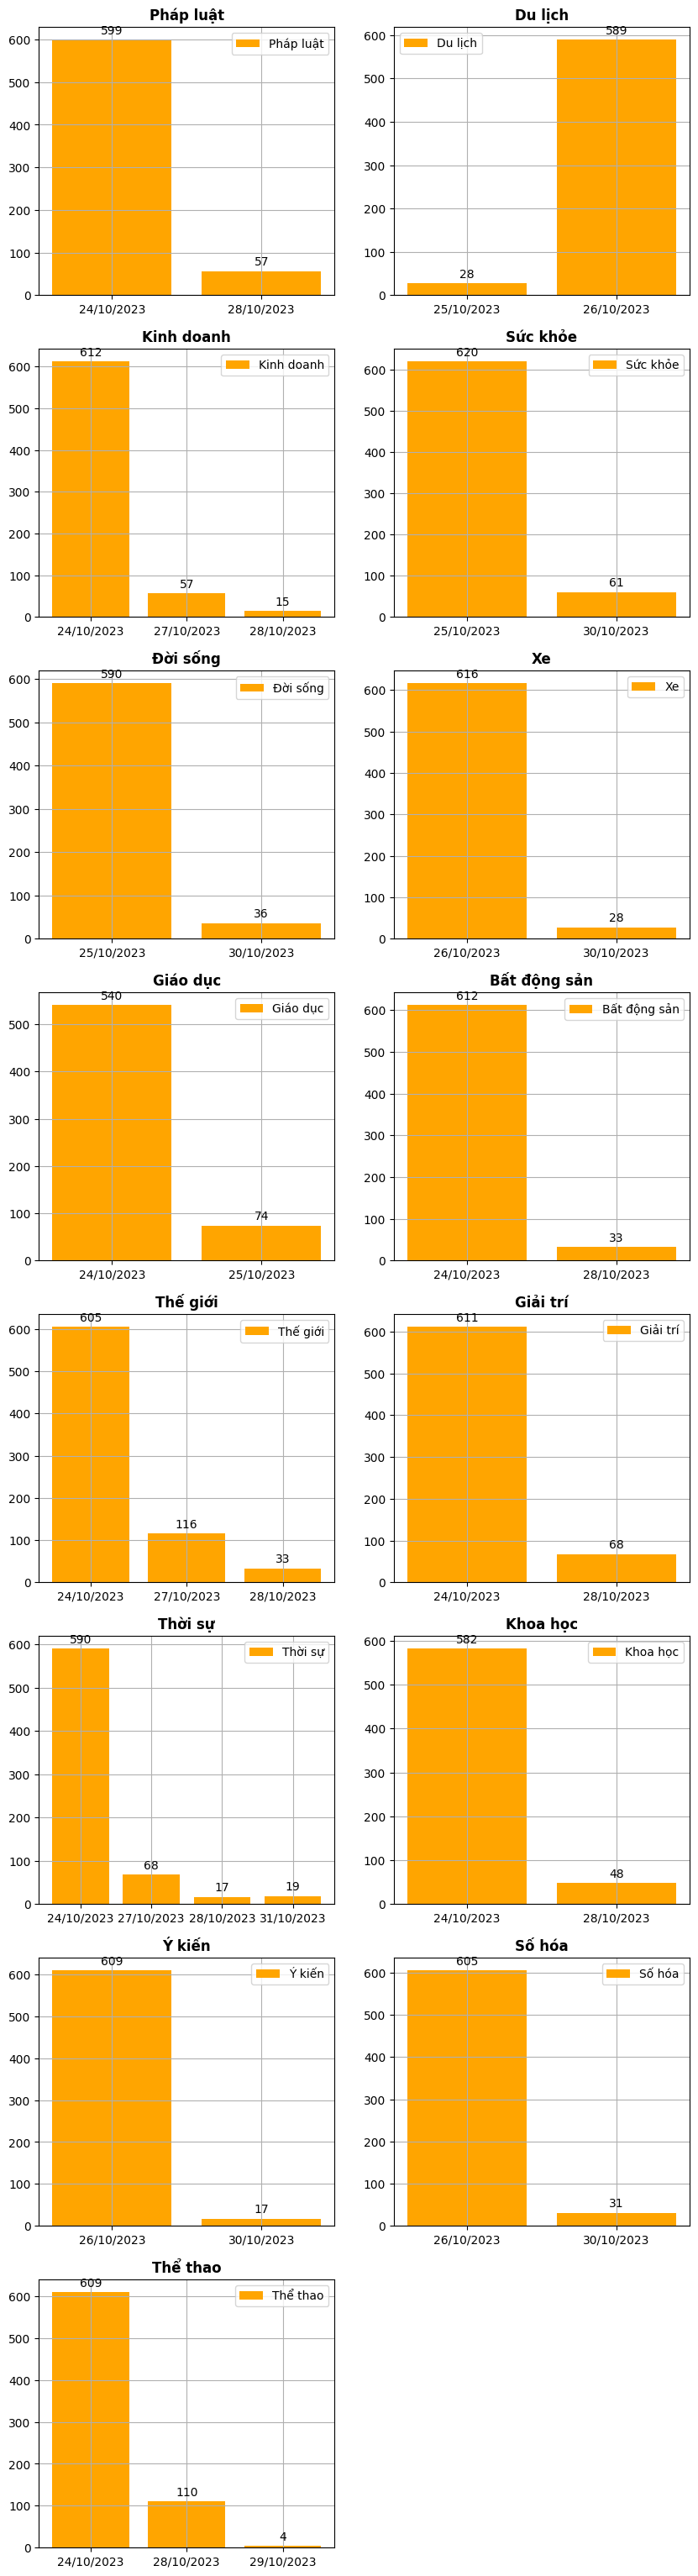

In [14]:
import psycopg2 as p
import psycopg2.extras as pe
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

hostname = '127.0.0.1'
database = 'news_page_keywords'
username = 'postgres'
password = 'test123456'
port = 5432
conn = None
import numpy as np

try:
    with p.connect(host = hostname, dbname = database, user = username, password = password, port = port ) as conn:
        with conn.cursor(cursor_factory = pe.DictCursor) as cur:
            
            get_news_script= '''SELECT genre,COUNT(*),date FROM news GROUP BY genre,date ORDER BY date '''
            cur.execute(get_news_script)
            
            result_news = cur.fetchall()

            if result_news:
                count_news = []
                date = []
                genre = []
                for result in result_news:
                    count_news.append(result[1])
                    date_string = result["date"].strftime("%d/%m/%Y")
                    date.append(date_string)
                    genre.append(result['genre'])

                fig_title, ax_title = plt.subplots(figsize=(10, 1))
                fig_title.suptitle('\n\n\nSỐ LƯỢNG BÀI BÁO ĐƯỢC THU THẬP THEO NGÀY', fontweight="bold")
                ax_title.axis('off')
                fig, axes = plt.subplots(8, 2, figsize=(10, 10), sharex=False, sharey=False)
                plt.subplots_adjust(bottom=5, top=8)
                
                
            
                r =0
                c = 0
                for g in set(genre):
                    ax = axes[r, c]

                    # Filter data for the current genre
                    data_x = [date[i] for i, genre in enumerate(genre) if genre == g]
                    data_y = [count_news[i] for i, genre in enumerate(genre) if genre == g]

                  
                    ax.bar(data_x, data_y, label=g, color = 'orange')
                
                    # Plot your data here using data_x and data_y
                    # ax.bar(data_x, data_y, label=g, alpha=0.5)
                    ax.set_title(g, fontweight="bold")
                    ax.grid(True)                  
                    ax.legend()

                    for i, val in enumerate(data_y):
                        ax.annotate(str(val), (data_x[i], val), textcoords="offset points", xytext=(0, 5), ha='center')

                    c += 1
 
                    if c > 1:
                        r += 1
                        c =0
                        
                plt.delaxes(axes[-1, -1])
                plt.show()
            else:
                print('sai url')
            
            
        
except Exception as error:
    print(error)
finally:
    if conn is not None:
        conn.close()


In [11]:
import psycopg2 as p
import psycopg2.extras as pe


hostname = '127.0.0.1'
database = 'news_page_keywords'
username = 'postgres'
password = 'test123456'
port = 5432
conn = None


try:
    with p.connect(host = hostname, dbname = database, user = username, password = password, port = port ) as conn:
        with conn.cursor(cursor_factory = pe.DictCursor) as cur:
                # hien thi noi dung url, title

            base_url = "https://vnexpress.net/dong-doi-o-al-nassr-tang-banh-mung-moc-ghi-ban-cua-ronaldo-4667318.html"
            select_script = '''SELECT * FROM news WHERE source = %s'''
            cur.execute(select_script, (base_url,))
            result = cur.fetchone()

            if result:
                select_script = '''SELECT COUNT(*) FROM news_keywords WHERE id_news = %s'''
                cur.execute(select_script, (result["id_news"],))
                result_count = cur.fetchone()
                date_string = result["date"].strftime("%d/%m/%Y")

                print(f"Bài báo: {result['title']}, được lấy dữ liệu từ ngày {date_string}\n\
Thể loại :{result['genre']}\n\
Đã thu thập được: {result_count[0]} keywords\n\
Có url: {result['source']}\n\n\
Mô tả ngắn :\n{result['description']}\n\n\
Có nội dung:\n{result['content']}")

            else:
                print("Không tìm thấy bài báo trong cơ sở dữ liệu.")
            

except Exception as error:
    print(error)
finally:
    if conn is not None:
        conn.close()

        
        


Bài báo: Đồng đội ở Al Nassr tặng bánh mừng mốc ghi bàn của Ronaldo - VnExpress Thể thao, được lấy dữ liệu từ ngày 24/10/2023
Thể loại :Thể thao
Đã thu thập được: 328 keywords
Có url: https://vnexpress.net/dong-doi-o-al-nassr-tang-banh-mung-moc-ghi-ban-cua-ronaldo-4667318.html

Mô tả ngắn :
Arab SaudiTiền đạo Cristiano Ronaldo được các đồng đội tại Al Nassr tặng chiếc bánh khổng lồ dịp cán mốc ghi 40 bàn trong năm 2023.

Có nội dung:
Trong quãng nghỉ quốc tế vừa rồi, Ronaldo lập hai cú đúp giúp Bồ Đào Nha lần lượt hạ Slovakia 3-2 và Bosnia 5-0 để giành vé dự VCK Euro 2024 sớm hai lượt. Nhờ đó, tiền đạo này cán mốc 40 bàn và chín kiến tạo qua 43 trận cho Al Nassr và tuyển Bồ Đào Nha trong năm 2023.
Tiền đạo 38 tuổi trở thành cầu thủ ghi nhiều bàn nhất trong năm 2023, vượt mặt hai đàn em là Erling Haaland (39 bàn) và Kylian Mbappe (35 bàn). Trung bình, Ronaldo ghi 0,93 bàn mỗi trận, và 76,7 phút cho một lần ghi dấu giày vào bàn thắng.
Khi trở lại Al Nassr, Ronaldo nhận được món quà bất n

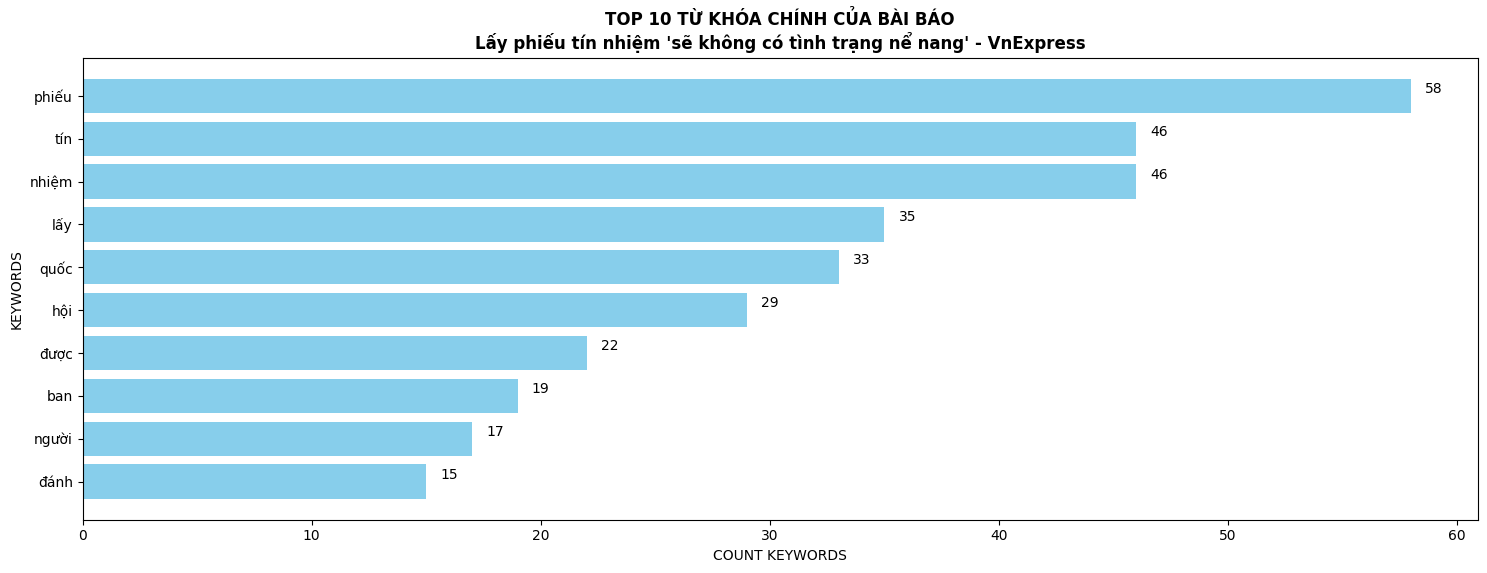

In [22]:
import psycopg2 as p
import psycopg2.extras as pe
import pandas as pd
import matplotlib.pyplot as plt

hostname = '127.0.0.1'
database = 'news_page_keywords'
username = 'postgres'
password = 'test123456'
port = 5432
conn = None


try:
    with p.connect(host = hostname, dbname = database, user = username, password = password, port = port ) as conn:
        with conn.cursor(cursor_factory = pe.DictCursor) as cur:
            
            url = 'https://vnexpress.net/lay-phieu-tin-nhiem-se-khong-co-tinh-trang-ne-nang-4664468.html'
            get_id_news_script= '''SELECT * FROM news WHERE source = %s'''
            cur.execute(get_id_news_script, (url,))
            result = cur.fetchone()

            title_news = ''
            if result is not None:
                title_news = result["title"]
                result_id_news = result["id_news"]
                get_id_keywords_script = '''SELECT * FROM news_keywords WHERE id_news = %s'''
                cur.execute(get_id_keywords_script, (result_id_news,))
                result_id_keywords = cur.fetchall()
                id_keywords = []
                for key in result_id_keywords:
                    id_keywords.append(key["id_keywords"])     
            else:
                print('this url is wrong')
                
            if id_keywords :
                top5_keywords_script = '''SELECT * FROM keyword_statistics kw_s INNER JOIN keywords kw ON kw_s.id_keywords = kw.id_keywords 
                                        WHERE kw.id_keywords = %s'''
                key_count = ()
                key_count_list = []
                for id in id_keywords:
                    cur.execute(top5_keywords_script, (id,))
                    result = cur.fetchone()
                    key_count_list.append((result["keyword"],result["count"]))
            else:
                print('dont has keywords')
            key_count = tuple(key_count_list)


            if key_count:
                # lay gia tri key, count trong tuple ra
                first_10_elements = key_count[:10]
                keywords = [item[0] for item in first_10_elements]
                count_key = [item[1] for item in first_10_elements]
    
                reversed_keywords = list(reversed(keywords))
                reversed_count = list(reversed(count_key))          
                
                plt.figure(figsize=(18, 6))

                for i, c in enumerate(reversed_count):
                        plt.text(c + 1, i, str(c), ha='center', va='bottom')
                
                # # Vẽ biểu đồ cột
                plt.barh(reversed_keywords,reversed_count,color='skyblue')

                # plt.xticks(reversed_count)
                plt.title(f"TOP 10 TỪ KHÓA CHÍNH CỦA BÀI BÁO\n{title_news}", fontweight="bold")
                plt.xlabel('COUNT KEYWORDS')
                plt.ylabel('KEYWORDS')
                plt.show()
except Exception as error:
    print(error)
finally:
    if conn is not None:
        conn.close()

        
        


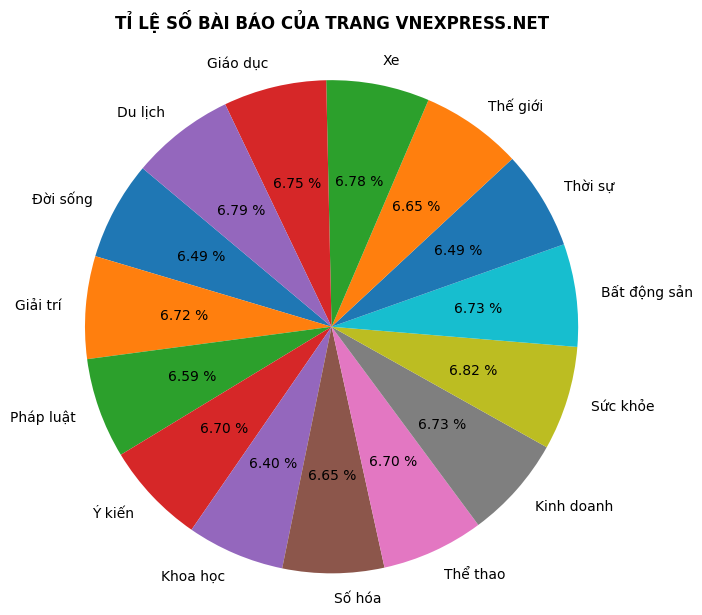

In [120]:
import matplotlib.pyplot as plt
import psycopg2 as p
import psycopg2.extras as pe
import time
import os
import pandas as pd
import matplotlib.pyplot as plt

hostname = '127.0.0.1'
database = 'news_page_keywords'
username = 'postgres'
password = 'test123456'
port = 5432
conn = None


try:
    with p.connect(host = hostname, dbname = database, user = username, password = password, port = port ) as conn:
        with conn.cursor(cursor_factory = pe.DictCursor) as cur:
            
            script = '''SELECT genre,COUNT(genre) FROM news GROUP BY genre '''
            cur.execute(script)

            result = []
            for data in cur.fetchall():
                result.append((data[0], data[1]))
                
            
            if result:
                labels = [item[0] for item in result]
                sizes =  [item[1] for item in result]
                
                plt.figure(figsize=(7, 7))
                
                # Tạo biểu đồ tròn
                plt.pie(sizes, labels=labels, autopct='%.2f %%', startangle=140)
                plt.axis('equal')  # Đảm bảo biểu đồ tròn là hình tròn
                plt.title('TỈ LỆ SỐ BÀI BÁO CỦA TRANG VNEXPRESS.NET\n', fontweight="bold") 
                
                
                # Hiển thị biểu đồ
                plt.show()
except Exception as error:
    print(error)
finally:
    if conn is not None:
        conn.close()

        
        


[17, 601, 3, 3, 63]


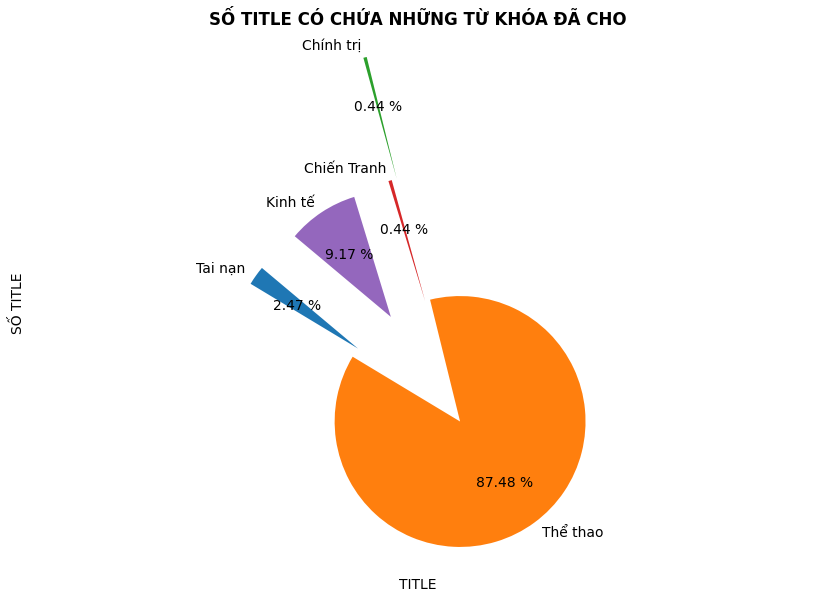

In [57]:
import psycopg2 as p
import psycopg2.extras as pe
import time
import os
import pandas as pd
import matplotlib.pyplot as plt

hostname = '127.0.0.1'
database = 'news_page_keywords'
username = 'postgres'
password = 'test123456'
port = 5432
conn = None


try:
    with p.connect(host = hostname, dbname = database, user = username, password = password, port = port ) as conn:
        with conn.cursor(cursor_factory = pe.DictCursor) as cur:

            keywords = ['Tai nạn', 'Thể thao', 'Chính trị', 'Chiến Tranh', 'Kinh tế']
            script_query = 'SELECT'     
            for key in keywords:
                script_query += f" SUM (CASE WHEN title ILIKE '%{key}%' THEN 1 ELSE 0 END),"
            script_query = script_query.rstrip(',')
            script_query += ' FROM news'
            cur.execute(script_query)

            result = cur.fetchone()
                    
            if result:
                count_title = []
                for i, key in enumerate(keywords):
                    count_title.append(result[i])
                print(count_title)
                plt.figure(figsize=(10, 7))

                # # Thêm giá trị lên các cột
                # for i, count in enumerate(count_title):
                #     plt.text(keywords[i], count, str(count), ha='center', va='bottom')
                
                # Tạo biểu đồ tròn
                explode = (1.0, 0, 2, 1, 1)
                plt.pie(count_title, labels=keywords, autopct='%.2f %%', startangle=140, explode=explode)
                plt.axis('equal')  # Đảm bảo biểu đồ tròn là hình tròn
                plt.title('SỐ TITLE CÓ CHỨA NHỮNG TỪ KHÓA ĐÃ CHO', fontweight="bold") 
                            
                # Hiển thị biểu đồ
                plt.show()
            else:
                print('TRY AGAIN!')
except Exception as error:
    print(error)
finally:
    if conn is not None:
        conn.close()

        
        


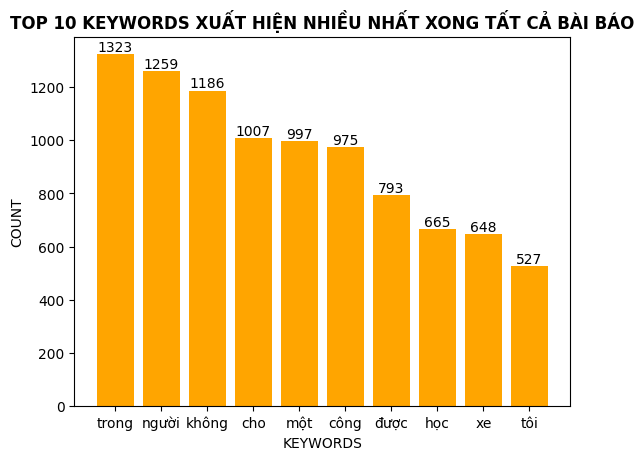

In [30]:
import psycopg2 as p
import psycopg2.extras as pe
import time
import os
import pandas as pd
import matplotlib.pyplot as plt

hostname = '127.0.0.1'
database = 'news_page_keywords'
username = 'postgres'
password = 'test123456'
port = 5432
conn = None


try:
    with p.connect(host = hostname, dbname = database, user = username, password = password, port = port ) as conn:
        with conn.cursor(cursor_factory = pe.DictCursor) as cur:

            cur.execute('SELECT id_news FROM news')
            id_news = []
            for id in cur.fetchall():
                id_news.append(id[0])

            id_keywords = []
            for id in id_news:
                cur.execute('SELECT id_keywords FROM news_keywords WHERE id_news = %s LIMIT 5', (id,))
                for id in cur.fetchall():
                    id_keywords.append(id[0])

    
            placeholders = ', '.join(['%s'] * len(id_keywords))
            cur.execute(f'''SELECT kw.keyword, COUNT(count) as soLanXuatHien 
                FROM keyword_statistics kw_s INNER JOIN keywords kw 
                ON kw_s.id_keywords = kw.id_keywords 
                WHERE kw_s.id_keywords IN ({placeholders})
                GROUP BY kw.keyword ORDER BY COUNT(count) DESC''', id_keywords)
            result = cur.fetchall()

            keyword_count = []
            if result:
                for data in result:
                    keyword_count.append((data[0], data[1]))
                
 
                keyword = [item [0] for item in keyword_count]
                count = [item [1] for item in keyword_count]
         
                # Thêm giá trị lên từng cột
                for i, c in enumerate(count[:10]):
                    plt.text(keyword[i], c, str(c), ha='center', va='bottom')
                 # Vẽ biểu đồ cột
                plt.bar(keyword[:10],count[:10], color = 'orange')
                plt.title('TOP 10 KEYWORDS XUẤT HIỆN NHIỀU NHẤT XONG TẤT CẢ BÀI BÁO', fontweight="bold")
                plt.xlabel('KEYWORDS')
                plt.ylabel('COUNT')
                plt.show()
            else:
                print('TRY AGAIN!')

            
except Exception as error:
    print(error)
finally:
    if conn is not None:
        conn.close()

        


In [5]:
import psycopg2 as p
import psycopg2.extras as pe
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType



hostname = '127.0.0.1'
database = 'news_page_keywords'
username = 'postgres'
password = 'test123456'
port = 5432
conn = None


try:
    with p.connect(host = hostname, dbname = database, user = username, password = password, port = port ) as conn:
        with conn.cursor(cursor_factory = pe.DictCursor) as cur:
            spark = SparkSession.builder.appName("TextClassification").getOrCreate()

            get_title_genre = '''SELECT title, genre FROM news'''
            cur.execute(get_title_genre)
            result = cur.fetchall()
                
            if result:
                title_genre = []
                for data in result:
                    title_genre.append((data['title'], data['genre']))
                    
                # Tạo DataFrame từ tập dữ liệu huấn luyện
                train_df = spark.createDataFrame(title_genre, ['title', 'genre'])
                train_df.show(truncate = False)

                genre_mapping = {
                    "Thời sự": 1,
                    "Thế giới": 2,
                    "Kinh doanh": 3,
                    "Bất động sản": 4,
                    "Khoa học": 5,
                    "Giải trí": 6,
                    "Thể thao": 7,
                    "Pháp luật": 8,
                    "Giáo dục": 9,
                    "Sức khỏe": 10,
                    "Đời sống": 11,
                    "Du lịch": 12,
                    "Số hóa": 13,
                    "Xe": 14,
                    "Ý kiến": 15
                    # Thêm ánh xạ cho các thể loại khác
                }


                def map_genre_to_int(genre):
                        return genre_mapping.get(genre, 0)

                # Ánh xạ cột "genre" thành số nguyên
                train_df = train_df.withColumn("genre", udf(map_genre_to_int)(col("genre")).cast(IntegerType()))

                
                # Tiền xử lý dữ liệu
                tokenizer = Tokenizer(inputCol="title", outputCol="words")
                stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
                vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
                lr = LogisticRegression(featuresCol="features", labelCol="genre")
                
                # Tạo một pipeline
                pipeline = Pipeline(stages=[tokenizer, stop_words_remover, vectorizer, lr])
    
                # Huấn luyện mô hình
                model = pipeline.fit(train_df)


                # get_random_title = '''SELECT title FROM news ORDER BY RANDOM() LIMIT 5'''
                # cur.execute(get_random_title)
                # result_random_title = cur.fetchall()

                # if result_random_title:
                    # title = []
                    # for data in result_random_title:
                    #     title.append(data['title'])

                title = ['Người cung cấp thông tin chống tham nhũng chính xác được chi trả tối đa 10 triệu đồng',
                        'Người Hồi giáo ở Nga truy lùng người Israel, Kremlin cáo buộc Ukraine kích động',
                         "Kỷ luật 4 cán bộ quản lý thị trường Long An đánh bạc ăn tiền",
                         'Việt Nam tham dự Hội chợ Du lịch quốc tế châu Á tại Singapore',
                         'Cựu HLV trưởng đội tuyển U23 Việt Nam dẫn dắt CLB Hà Nội'
                    ]
           
                # Tạo DataFrame từ tập dữ liệu dự đoán
                test_df = spark.createDataFrame([(text, 0) for text in title], ["title", "genre"])
                                                 
                # Dự đoán
                predictions = model.transform(test_df)

                # Hiển thị kết quả
                
                int_to_string_mapping = {v: k for k, v in genre_mapping.items()}

                def map_prediction_to_string(prediction):
                    return int_to_string_mapping.get(prediction, "Unknown")
                    
                predictions = predictions.withColumn("prediction", udf(map_prediction_to_string)(col("prediction")).cast(StringType()))
                predictions.select("title", "prediction").show(truncate=False)
except Exception as error:
    print(error)
finally:
    if conn is not None:
        conn.close()

        


+------------------------------------------------------------------------+-------+
|title                                                                   |genre  |
+------------------------------------------------------------------------+-------+
|Lấy phiếu tín nhiệm 'sẽ không có tình trạng nể nang' - VnExpress        |Thời sự|
|Hôm nay Quốc hội bắt đầu quy trình lấy phiếu tín nhiệm - VnExpress      |Thời sự|
|Trồng hồng trứng thu hơn 50 triệu đồng mỗi vụ - VnExpress               |Thời sự|
|Trợ cấp cho người đóng thừa năm bảo hiểm cần tương xứng - VnExpress     |Thời sự|
|Vợ chồng miền Tây làm giàu từ loài cây dại                              |Thời sự|
|Hàng chục cây hoa giấy bị cắt ngang thân - VnExpress                    |Thời sự|
|Trụ sở ủy ban quận, hầm chui ở TP HCM ngập do mưa lớn - VnExpress       |Thời sự|
|Sông Nhuệ ô nhiễm - VnExpress                                           |Thời sự|
|Sạt lở taluy ở Đà Lạt - VnExpress                                       |Thời sự|
|'Cầ

23/10/31 22:54:36 WARN DAGScheduler: Broadcasting large task binary with size 1192.2 KiB


+-------------------------------------------------------------------------------------+----------+
|title                                                                                |prediction|
+-------------------------------------------------------------------------------------+----------+
|Người cung cấp thông tin chống tham nhũng chính xác được chi trả tối đa 10 triệu đồng|Thời sự   |
|Người Hồi giáo ở Nga truy lùng người Israel, Kremlin cáo buộc Ukraine kích động      |Thế giới  |
|Kỷ luật 4 cán bộ quản lý thị trường Long An đánh bạc ăn tiền                         |Pháp luật |
|Việt Nam tham dự Hội chợ Du lịch quốc tế châu Á tại Singapore                        |Du lịch   |
|Cựu HLV trưởng đội tuyển U23 Việt Nam dẫn dắt CLB Hà Nội                             |Thể thao  |
+-------------------------------------------------------------------------------------+----------+

